# Amélioration des performances du modèle CNN


## Réalisé par : Ahmed Mrabet

Dans ce notebook, nous allons essayé d'améliorer les performances du modèle CNN qu'on a realiser en utilisant différentes techniques.

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## Nouveau modèle CNN

### Step 1: Dataset

In [4]:
img_height = 32
img_width = 32
batch_size = 64

train_dataset =  tf.keras.utils.image_dataset_from_directory("chest_xray_dataset/train/", image_size=(img_height, img_width), batch_size=batch_size)
test_dataset =  tf.keras.utils.image_dataset_from_directory("chest_xray_dataset/test/", image_size=(img_height, img_width), batch_size=batch_size)
validation_dataset =  tf.keras.utils.image_dataset_from_directory("chest_xray_dataset/validation/", image_size=(img_height, img_width), batch_size=batch_size)

Found 4833 files belonging to 3 classes.
Found 690 files belonging to 3 classes.
Found 1379 files belonging to 3 classes.


#### Visualisation des données

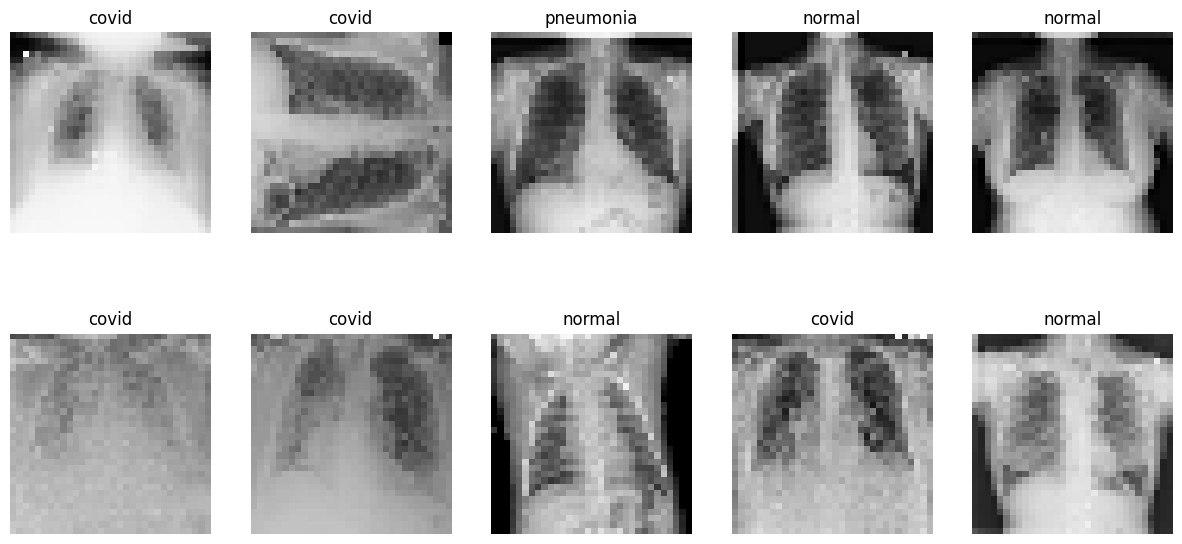

In [43]:
class_names = train_dataset.class_names
plt.figure(figsize=(15, 15))
for images, labels in train_dataset.take(1):
    for i in range(10):
        ax = plt.subplot(4, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

In [5]:
def convert_to_grayscale(image, label):
    image = tf.image.rgb_to_grayscale(image)  # Convert to grayscale
    return image, label

train_dataset = train_dataset.map(convert_to_grayscale)
validation_dataset = validation_dataset.map(convert_to_grayscale)
test_dataset = test_dataset.map(convert_to_grayscale)

### Data Augmentation

In [45]:
# data_augmentation = tf.keras.Sequential([
#     tf.keras.layers.RandomFlip("horizontal_and_vertical"),
#     tf.keras.layers.RandomRotation(0.2),
#     tf.keras.layers.RandomZoom(0.2),
#     tf.keras.layers.RandomBrightness(0.1)
# ])

# train_dataset = train_dataset.map(lambda image, label: (data_augmentation(image, training=True), label))

### Step 2: Création du modèle

In [6]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (
    Rescaling, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
)
from tensorflow.keras.regularizers import l2


In [7]:
model = Sequential([    
    Rescaling(1./255, input_shape=(img_height, img_width, 1)),
    
    Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    
    Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    
    Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.6),
    Dense(84, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(3, activation='softmax')  # 3 classes: Normal, Pneumonia, COVID
])

C:\Users\pc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Step 3: Paramétrage du modèle

In [48]:
model.compile(
  optimizer='adam', 
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), 
  metrics=['accuracy']
)

### Step 4: Training du modèle

In [49]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=30,
    callbacks=[early_stopping]
)

Epoch 1/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 14s 166ms/step - accuracy: 0.4573 - loss: 3.9806 - val_accuracy: 0.7447 - val_loss: 1.0100
Epoch 2/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 16s 213ms/step - accuracy: 0.7823 - loss: 0.9166 - val_accuracy: 0.8129 - val_loss: 0.7212
Epoch 3/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 16s 209ms/step - accuracy: 0.8437 - loss: 0.6526 - val_accuracy: 0.8796 - val_loss: 0.5143
Epoch 4/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 16s 210ms/step - accuracy: 0.8661 - loss: 0.5449 - val_accuracy: 0.8920 - val_loss: 0.4581
Epoch 5/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 16s 208ms/step - accuracy: 0.8844 - loss: 0.4874 - val_accuracy: 0.8861 - val_loss: 0.4521
Epoch 6/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 16s 205ms/step - accuracy: 0.8922 - loss: 0.4485 - val_accuracy: 0.9115 - val_loss: 0.3768
Epoch 7/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 16s 210ms/step - accuracy: 0.9053 - loss: 0.4144 - val_accuracy: 0.8847 - val_loss: 0.4451
Epoch 8/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 16s 210ms/step - accuracy: 0.8981 - loss: 0.4047 - val_accu

### Step 5: Test

In [50]:
model.evaluate(test_dataset, verbose=2)

11/11 - 2s - 161ms/step - accuracy: 0.9478 - loss: 0.2836


[0.2835925221443176, 0.947826087474823]

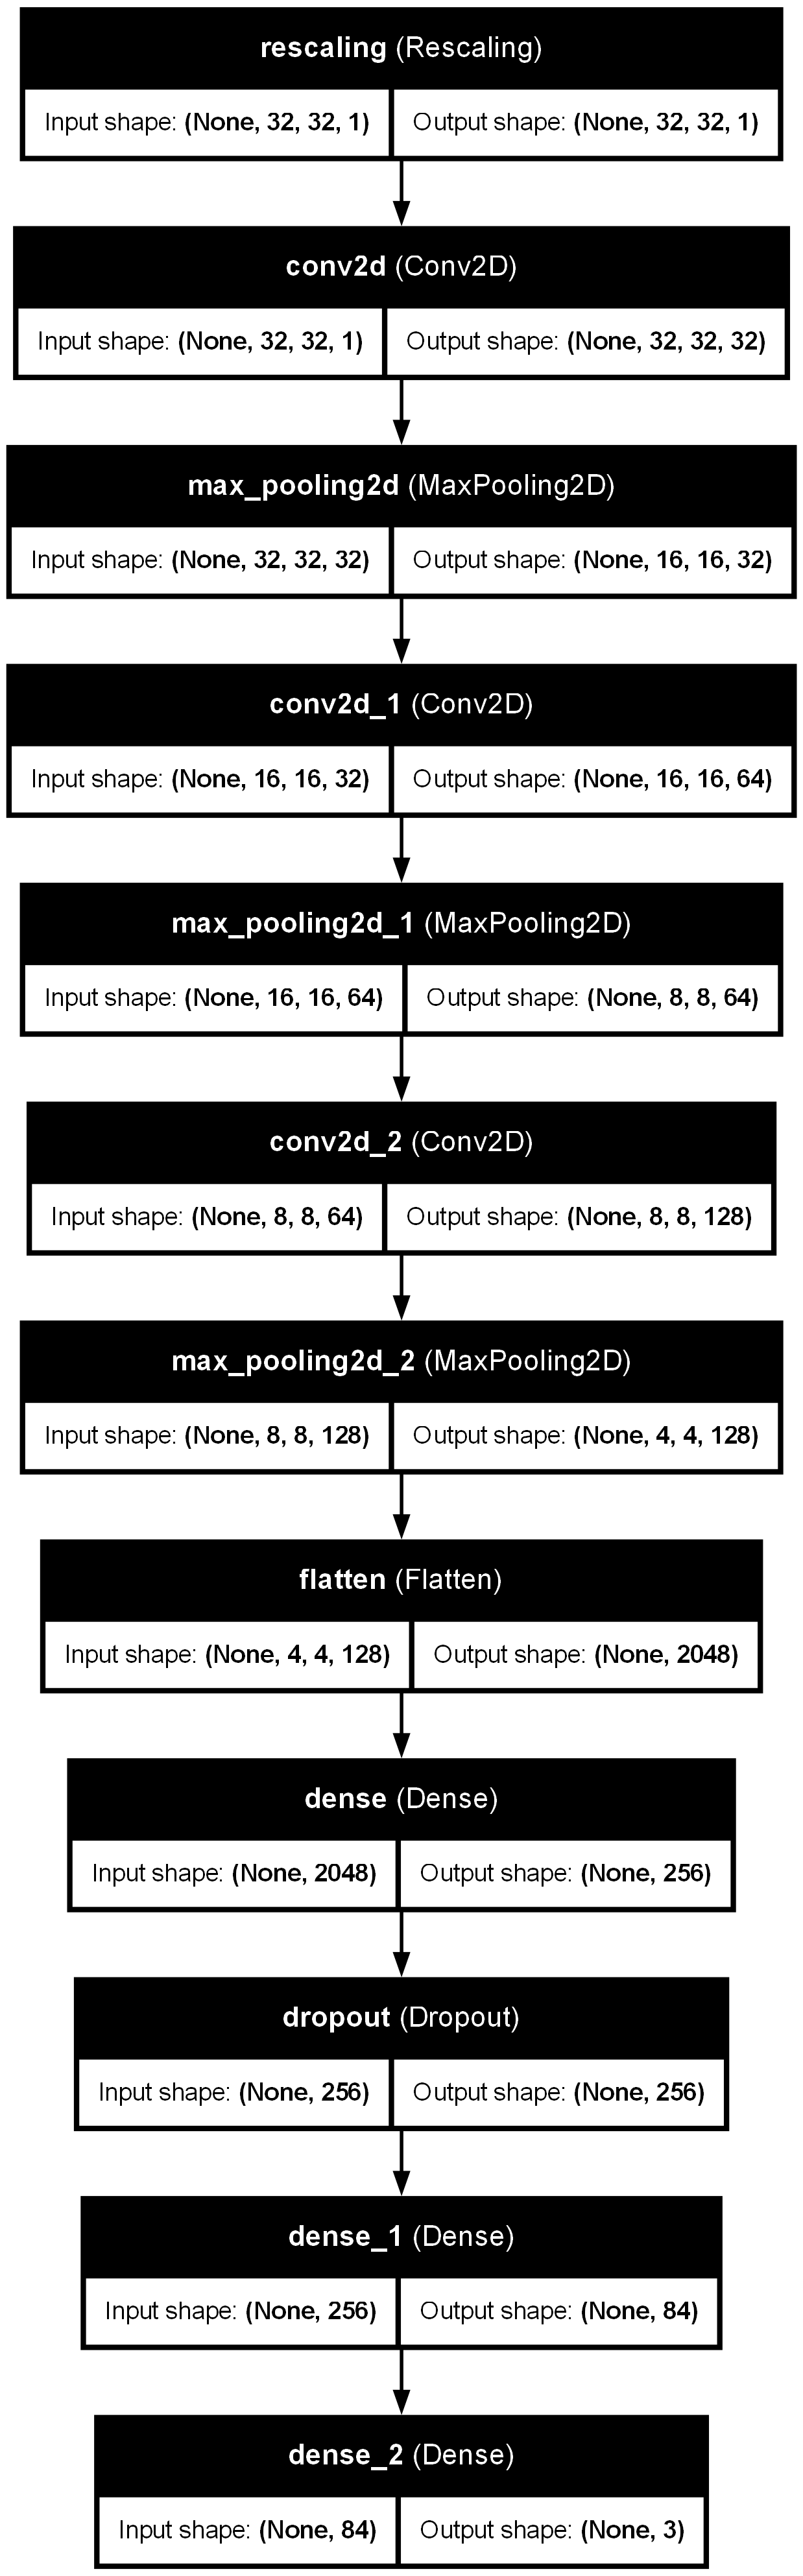

In [8]:
from tensorflow.keras.utils import plot_model

# Générer une représentation graphique
plot_model(model, to_file="model_architecture.png", show_shapes=True, show_layer_names=True)